In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print("Tensorflow version", tf.__version__)

Tensorflow version 2.9.1


       acc_x_0  acc_x_1  acc_x_2  acc_x_3  acc_x_4  acc_x_5  acc_x_6  acc_x_7  \
26050      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
26051      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
26052      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
26053      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
26054      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
26055      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
26056      1.0      1.0      1.0      1.0      1.0      1.0      1.0      2.0   
26057      1.0      1.0      1.0      1.0      1.0      1.0      2.0      1.0   
26058      1.0      1.0      1.0      1.0      1.0      2.0      1.0      1.0   
26059      1.0      1.0      1.0      1.0      2.0      1.0      1.0      1.0   

       acc_x_8  acc_x_9  ...  acc_z_40  acc_z_41  acc_z_42  acc_z_43  \
26050      1.0      1.0  ...       0

<Figure size 640x480 with 0 Axes>

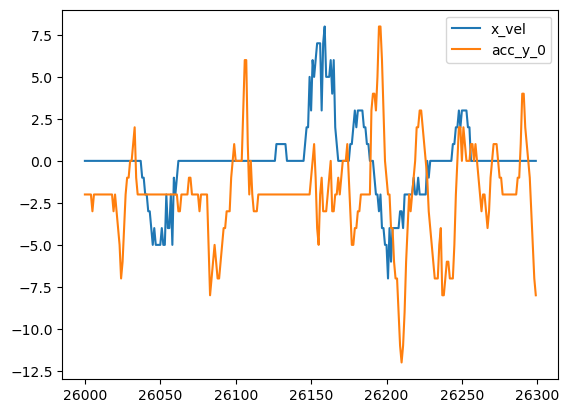

In [5]:
dataset = pd.read_csv('../data/dataset1-processed3.csv').astype(np.float32)

print(dataset[26050:26060])

plt.figure()
dataset[26000:26300].plot(y=['x_vel', 'acc_y_0'])
plt.legend(loc='best')
plt.show()

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# copy dataset
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# pick out labels
train_labels = train_features[['x_vel', 'y_vel']].copy()
test_labels = test_features[['x_vel', 'y_vel']].copy()


# drop labels from features
train_features = train_features.drop(['x_vel', 'y_vel'], axis=1)
test_features = test_features.drop(['x_vel', 'y_vel'], axis=1)

In [5]:
np.set_printoptions(precision=3, suppress=True)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

2022-12-09 09:10:15.984399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# build model

def build_and_compile_model(norm):
  model = keras.Sequential([
      layers.InputLayer(input_shape=((144,)), dtype=np.float32),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(2)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_mouse_model = build_and_compile_model(normalizer)
print(dnn_mouse_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               18560     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 43,458
Trainable params: 43,458
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history = dnn_mouse_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

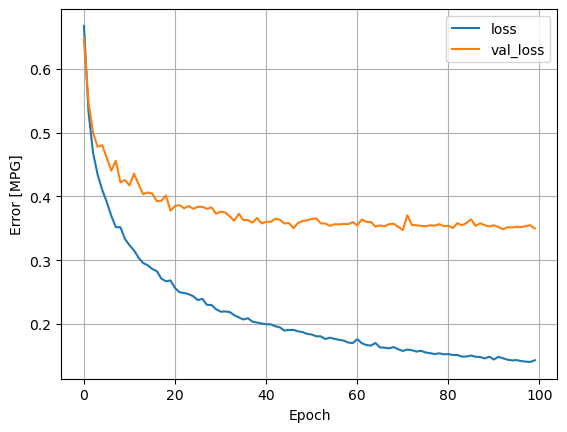

In [8]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

188/188 [==============================] - 0s 561us/step


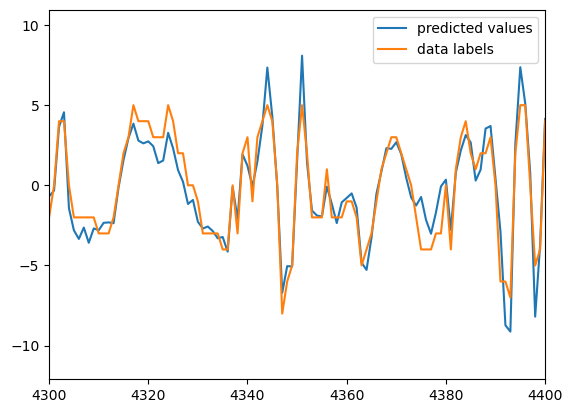

In [9]:

x = np.arange(0, len(test_labels))

plt.plot(x, dnn_mouse_model.predict(test_features).T[0], label="predicted values")
plt.plot(x, test_labels['x_vel'], label="data labels")
#plt.plot(x, test_features['acc_x_0'], label="acc_x")

plt.xlim(4300, 4400)
plt.legend()

# Convert the model

In [16]:
# Save as SavedModel

print(dnn_mouse_model)
print(type(dnn_mouse_model))

tf.saved_model.save(
    dnn_mouse_model, 'SavedModel/', signatures=None, options=None
)

<class 'keras.engine.sequential.Sequential'>
INFO:tensorflow:Assets written to: SavedModel/assets


INFO:tensorflow:Assets written to: SavedModel/assets


In [17]:
# Convert the SavedModel

#quantization

""" def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_features).batch(1).take(400):
        yield [tf.dtypes.cast(input_value, np.float32)] """

def representative_data_gen():
    num_samples = 2000
    samples = []
    random_rows = np.random.randint(len(test_features), size=num_samples)

    for i in range(num_samples):
        samples.append(np.array(test_features.iloc[random_rows[i], :]))

    samples = np.array(samples)
    img = tf.data.Dataset.from_tensor_slices(samples).batch(1)
    print(samples)
    for i in img.take(num_samples):
        yield [i]

def representative_dataset():
    for i in range(500):
        idx = np.random.randint(0, len(test_features))
        yield (np.array(test_features.iloc[idx:idx+1, :]))

#converter = tf.lite.TFLiteConverter.from_saved_model('SavedModel/')
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_mouse_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8  # or tf.uint8
#converter.inference_output_type = tf.int8  # or tf.uint8
converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmp_oo6ryqc/assets


INFO:tensorflow:Assets written to: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmp_oo6ryqc/assets


[[  1.   1.   1. ...   0.   0.   0.]
 [  1.   1.   1. ...   0.   0.   0.]
 [  1.   1.   1. ...   0.   0.   0.]
 ...
 [  1.   1.   1. ...   0.   0.   0.]
 [-13.   0.  -4. ...   0.   0.   0.]
 [  1.   1.   1. ...   0.   0.   0.]]


/Users/ursincantieni/opt/miniconda3/envs/coolmouse/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-09 06:43:30.564494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-09 06:43:30.564512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-09 06:43:30.564646: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmp_oo6ryqc
2022-12-09 06:43:30.565932: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-12-09 06:43:30.565944: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmp_oo6ryqc
2022-1

# Test TfLite model

In [18]:
columns = ["col" + str(i) for i in range(144)]
d = {
    columns[i] : [6]
    for i in range(144)
}
df = pd.DataFrame(data=d)
print(df)

print(dnn_mouse_model.predict(df)) 

   col0  col1  col2  col3  col4  col5  col6  col7  col8  col9  ...  col134  \
0     6     6     6     6     6     6     6     6     6     6  ...       6   

   col135  col136  col137  col138  col139  col140  col141  col142  col143  
0       6       6       6       6       6       6       6       6       6  

[1 rows x 144 columns]
1/1 [==============================] - 0s 14ms/step
[[25.575  8.199]]


2/2 [==============================] - 0s 1ms/step


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


Text(0.5, 1.0, 'X vel')

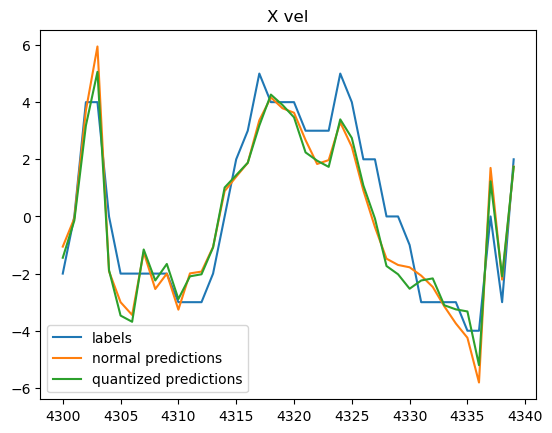

In [19]:
FROM = 4300
TO = 4340
PREDICT_QUANTIZED = True

X = 0
Y = 1
VAR = X

predictions_normal = dnn_mouse_model.predict(test_features.iloc[FROM:TO, :])
labels = test_labels.iloc[FROM:TO, VAR]

if PREDICT_QUANTIZED:
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    output = interpreter.get_output_details()[0]
    input = interpreter.get_input_details()[0]

    predictions_quantized = []
    for i in range(FROM, TO):
        input_data = tf.constant(test_features.iloc[i:i+1, :], dtype=np.float32) #dtype=np.int8
        interpreter.set_tensor(input['index'], input_data)
        interpreter.invoke()
        predictions_quantized.append(interpreter.get_tensor(output['index'])[0])
    predictions_quantized = np.array(predictions_quantized)

x = [i for i in range(FROM, TO)]
plt.plot(x, labels, label='labels')
plt.plot(x, predictions_normal[:,VAR], label='normal predictions')
if PREDICT_QUANTIZED:
    plt.plot(x, predictions_quantized[:,VAR], label='quantized predictions')
plt.legend()
plt.title('{} vel'.format(VAR * 'Y' + (1 - VAR) * 'X'))

<Figure size 640x480 with 0 Axes>

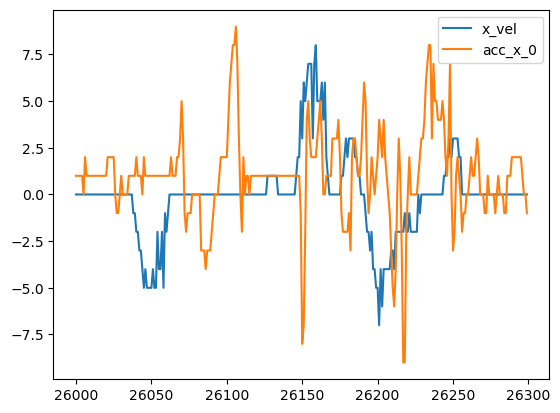

In [47]:
#print(dataset[2600:26300])

#dataset[26000:26300].to_csv('samples.csv', sep=',')
#dataset[26000:26300].to_clipboard(sep=',')
with open('samples.txt', 'w') as f:
    for i in range(30):
        f.write(str(list(dataset[26000+i:26001+i].to_numpy()[0])).replace("[", "").replace("]", "") + ", ")

plt.figure()
dataset[26000:26300].plot(y=['x_vel', 'acc_x_0'])
plt.legend(loc='best')
plt.show()

In [36]:
l = []

for i in range(100):
    l.append("sample{}".format(i))

print(l)

['sample0', 'sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7', 'sample8', 'sample9', 'sample10', 'sample11', 'sample12', 'sample13', 'sample14', 'sample15', 'sample16', 'sample17', 'sample18', 'sample19', 'sample20', 'sample21', 'sample22', 'sample23', 'sample24', 'sample25', 'sample26', 'sample27', 'sample28', 'sample29', 'sample30', 'sample31', 'sample32', 'sample33', 'sample34', 'sample35', 'sample36', 'sample37', 'sample38', 'sample39', 'sample40', 'sample41', 'sample42', 'sample43', 'sample44', 'sample45', 'sample46', 'sample47', 'sample48', 'sample49', 'sample50', 'sample51', 'sample52', 'sample53', 'sample54', 'sample55', 'sample56', 'sample57', 'sample58', 'sample59', 'sample60', 'sample61', 'sample62', 'sample63', 'sample64', 'sample65', 'sample66', 'sample67', 'sample68', 'sample69', 'sample70', 'sample71', 'sample72', 'sample73', 'sample74', 'sample75', 'sample76', 'sample77', 'sample78', 'sample79', 'sample80', 'sample81', 'sample82', 'sample83', '

[ 0.072  0.     0.072  0.     0.     0.    -0.072  0.    -0.072  0.072
  0.     0.     0.     0.     0.     0.217 -0.072 -0.072  0.072  0.
 -0.145  0.072  0.    -0.145  0.     0.217  0.     0.217  0.145  0.072]
1/1 [==============================] - 0s 16ms/step


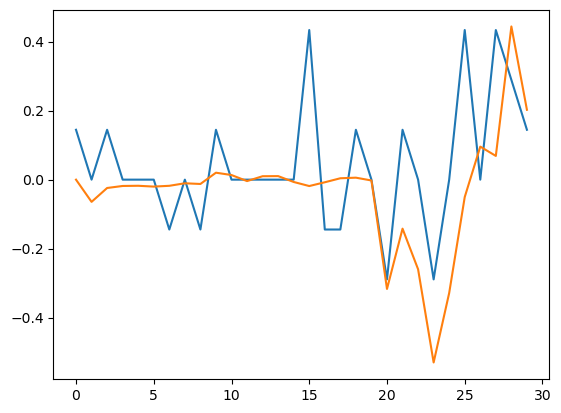

In [73]:
pred_baord = np.array([[0.072276, 0.000000],
[0.000000, -0.072276],
[0.072276, 0.000000],
[0.000000, 0.000000],
[0.000000, 0.072276],
[0.000000, 0.000000],
[-0.072276, 0.000000],
[0.000000, 0.000000],
[-0.072276, 0.000000],
[0.072276, 0.000000],
[0.000000, 0.000000],
[0.000000, -0.072276],
[0.000000, 0.000000],
[0.000000, 0.000000],
[0.000000, 0.000000],
[0.216829, -0.144553],
[-0.072276, 0.072276],
[-0.072276, 0.072276],
[0.072276, 0.000000],
[0.000000, 0.000000],
[-0.144553, 0.000000],
[0.072276, 0.000000],
[0.000000, 0.144553],
[-0.144553, -0.433659],
[0.000000, -0.072276],
[0.216829, 0.795041],
[0.000000, 1.879188],
[0.216829, 1.445529],
[0.144553, 0.795041],
[0.072276, 0.072276]])

print(pred_baord[:, 0])

x = [i for i in range(30)]

plt.plot(x, 2 * pred_baord[:,0], label='board')
plt.plot(x, dnn_mouse_model.predict(dataset.drop(columns=['x_vel', 'y_vel'])[26000:26030])[:, 0], label='normal')

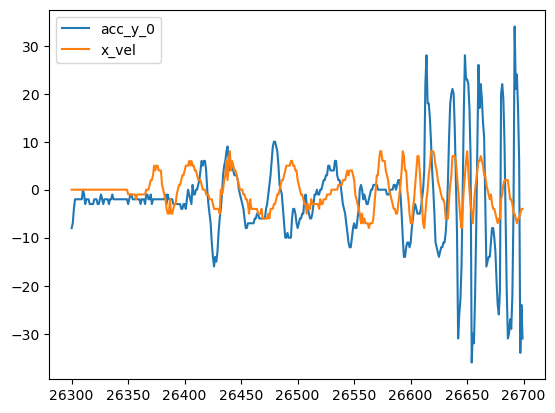

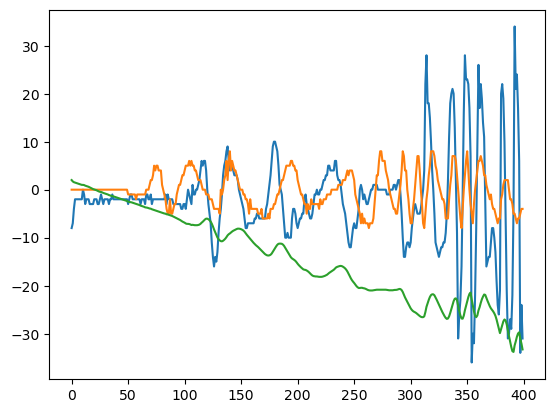

In [44]:
dataset[26300:26700].plot(y=['acc_y_0', 'x_vel'])

acc_x = [dataset.loc[26300+i]['acc_y_0'] for i in range(400)]
x_vel = [dataset.loc[26300+i]['x_vel'] for i in range(400)]
lol = [2]

for i in range(1, len(acc_x)):
    last = lol[-1]
    lol.append(last + acc_x[i] / 25)

x = [i for i in range(400)]
plt.figure()
plt.plot(x, acc_x)
plt.plot(x, x_vel)
plt.plot(x, lol)